## This code uses measured Quality factor (Q=1/loss) data for 3 samples: 
## [1 coated with a 2-material HR stack] 

## [2 coated with a single layer of each material] 





# Then we:


## (1) quantify the coating Q/loss of the stack from measurements and pull out key variables mode frequencies, dilution factors, strains 

## (2) estimate the effective media Qs/loss trend of a theoretical stack made of the two single layer data sets. 

## and
## (3) compare that with the measured values of the real stack sample


In [9]:
#Import some useful packages
import warnings
warnings.filterwarnings('ignore')
from numpy import *
import numpy
%matplotlib inline
from pylab import *
from matplotlib.colors import LogNorm
import os
import time
from scipy.signal import *
#import nds2
import pickle
import sys
from tqdm.notebook import tqdm
import pandas as pd
import random
import numpy_groupies as npg

# Function to convert the plot to base64 for HTML embedding
import base64
from io import BytesIO
from IPython.display import display, HTML



matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'figure.figsize': (10,6)})

def save_fig(fig_id, tight_layout=True):
    path = fig_id + '.png'
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=100)
def save_fig_pdf(fig_id, tight_layout=True):
    path = fig_id + '.pdf'
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='pdf', dpi=100)
def pcolormesh_logscale(T, F, S):
    pcolormesh(T, F, S, norm=LogNorm(vmin=S.min(), vmax=S.max()))

In [10]:
def summarise(data, all=False):
    summaries = []

    # Function to generate summary for the current data
    def generate_summary(data, parent_key='', level=0):
        if isinstance(data, dict):
            for key, value in data.items():
                new_key = f"{parent_key}.{key}" if parent_key else key
                summaries.append((level, new_key, type(value).__name__, np.shape(value) if isinstance(value, float) else (len(value) if hasattr(value, '__len__') else 'N/A')))
                if all and isinstance(value, (dict, list, np.ndarray)):
                    generate_summary(value, new_key, level + 1)
        elif isinstance(data, (list, np.ndarray)):
            for index, value in enumerate(data):
                new_key = f"{parent_key}[{index}]" if parent_key else str(index)
                summaries.append((level, new_key, type(value).__name__, np.shape(value) if isinstance(value, float) else (len(value) if hasattr(value, '__len__') else 'N/A')))
                if all and isinstance(value, (dict, list, np.ndarray)):
                    generate_summary(value, new_key, level + 1)
    
    generate_summary(data)

    # Sorting summaries by level to ensure high-level summaries are printed first
    summaries.sort(key=lambda x: x[0])

    # Removing the level information now that sorting is done
    formatted_summaries = [(key, type_, size) for _, key, type_, size in summaries]

    # Printing the high-level summary followed by all sub-key entries
    print("Total items:", len(data))
    print(tabulate(formatted_summaries, headers=["Key", "Type", "Size/Length"], tablefmt="grid"))
    
    
def calculate_density(refractive_indx, num_layers, layer_density, wavelength):
    layer_thickness = [wavelength / (4 * r_indx) for r_indx in refractive_indx]

    densities = []
    thicknesses_by_layer = []
    for i in range(len(layer_thickness)):
        density_i = (layer_thickness[i] * num_layers[i] * layer_density[i])
        densities.append(density_i)
        thicknesses_by_layer.append(layer_thickness[i] * num_layers[i])   

    numerator = sum(densities)

    denominator = 0
    for i in range(len(layer_thickness)):
        denominator += layer_thickness[i] * num_layers[i]

    density = numerator / denominator

    return density ,denominator,thicknesses_by_layer


In [11]:
wavelength =  1064E-9
 
serials         = ["S1600962"    ,"S1600963"    ,"S1600964"    ,"S1600965"    ,"S1600966"    ,"S1600967"    ,"S1600968"  ,"S1600969"  ,"S1600970","S1600971","S1600972","S1600973"]
materials       = ["50LayerStack","50LayerStack","40LayerStack","40LayerStack","30LayerStack","30LayerStack","TiGeO/SiO2","TiGeO/SiO2","SiO2"   ,"SiO2",   "TiGeO/SiO2","TiGeO/SiO2"]
layers          = [50            ,50            ,40             ,40             ,30          , 30           , 2          ,2           ,2        ,2      ,1             ,1 ]
layer_density   = [3600         ,2202]
refractive_indx = [1.88         ,1.45]




# Initialize num_layers list
num_layers = []

import re 
d_1 = []
d_2 = []
d_T = []

av_stack_density = [] 


for serial in serials:
    
    
    
    index = serials.index(serial)
    if "TiGeO/SiO2" in materials[index]:
        num_layers = [layers[index], 0]
    elif "SiO2" in materials[index]:
        num_layers = [0,layers[index]]
    elif "Stack" in materials[index]:
        # Extract integer value from the string using regular expression
        extracted_integer = int(re.search(r'\d+', materials[index]).group())
        num_layers = [extracted_integer // 2, extracted_integer // 2]
    else:
        num_layers = [0, 0]  # Default value if none of the conditions are met
        
    density ,total_thickness,layer_thickness = calculate_density(refractive_indx, num_layers, layer_density, wavelength)
    av_stack_density.append(density)
    d_T.append(total_thickness)
    d_1.append(layer_thickness[0])
    d_2.append(layer_thickness[1])



In [12]:
"""
#Define NEW stack properties

d_1 = 140.9*5                            #define total thickness of stack material 1 in [nm] here example of 20 ~QWL layers of TiO2:GeO2 @1064nm
d_2 = 178.9*5                            #define total thickness of stack material 2 in [nm] here example of 21 ~QWL layers of SiO2 @1064nm
d_T = d_1 +d_2                           #Total stack thickness



g1 = d_1/d_T                             #thickness ratios
g2 =d_2/d_T

rho_1 = 3690                             #density of material 1 in kg/m^3
rho_2 = 2220                             #density of material 2 in kg/m^3

av_stack_density = g2*rho_2 + g2*rho_1 #thickness weighted average density of stack
"""

'\n#Define NEW stack properties\n\nd_1 = 140.9*5                            #define total thickness of stack material 1 in [nm] here example of 20 ~QWL layers of TiO2:GeO2 @1064nm\nd_2 = 178.9*5                            #define total thickness of stack material 2 in [nm] here example of 21 ~QWL layers of SiO2 @1064nm\nd_T = d_1 +d_2                           #Total stack thickness\n\n\n\ng1 = d_1/d_T                             #thickness ratios\ng2 =d_2/d_T\n\nrho_1 = 3690                             #density of material 1 in kg/m^3\nrho_2 = 2220                             #density of material 2 in kg/m^3\n\nav_stack_density = g2*rho_2 + g2*rho_1 #thickness weighted average density of stack\n'

In [13]:
# Get all measurement dates 
uncoated_measurements = {'S1600968': ['2023_08_25', '2023_08_29'],
  'S1600969': ['2023_08_25', '2023_08_29'],
  'S1600970': ['2023_08_26', '2023_08_30'],
  'S1600971': ['2023_08_26', '2023_08_30'],
  'S1600972': ['2023_08_26', '2023_08_30'],
  'S1600973': ['2023_08_26', '2023_08_30'],
  'S1600962': ['2023_08_24', '2023_08_28'],
  'S1600963': ['2023_08_24', '2023_08_28'],
  'S1600964': ['2023_08_24', '2023_08_28'],
  'S1600965': ['2023_08_24', '2023_08_28', ''],
  'S1600966': ['2023_08_25', '2023_08_29', ''],
  'S1600967': ['2023_08_25', '2023_08_29', '']}
 
coated_measurements = {'S1600968': ['2023_11_30', '2023_12_18'],
  'S1600969': ['2023_11_30', '2023_12_18'],
  'S1600970': ['2023_11_30', '2023_12_18'],
  'S1600971': ['2023_11_30', '2023_12_18'],
  'S1600972': ['2023_12_19', '2023_12_20'],
  'S1600973': ['2023_12_19', '2023_12_20'],
  'S1600962': ['2023_12_19', '2023_12_20'],
  'S1600963': ['2023_12_19', '2023_12_20'],
  'S1600964': ['2023_12_19', '2023_12_22'],
  'S1600965': ['2023_12_19', '2023_12_20', '2023_12_22'],
  'S1600966': ['2023_12_19', '2023_12_20', '2023_12_22'],
  'S1600967': ['2023_12_19', '2023_12_20', '2023_12_22']}

 
HT1_measurements =  {'S1600968': ['2024_01_09', '2024_01_11'],
  'S1600969': ['2024_01_09', '2024_01_11'],
  'S1600970': ['2024_01_10', '2024_01_11'],
  'S1600971': ['2024_01_10', '2024_01_11'],
  'S1600972': ['2024_01_10', '2024_01_11'],
  'S1600973': ['2024_01_10', '2024_01_11'],
  'S1600962': ['2024_01_09', '2024_01_10'],
  'S1600963': ['2024_01_09', '2024_01_10'],
  'S1600964': ['2024_01_09', '2024_01_10'],
  'S1600965': ['2024_01_09', '2024_01_10', ''],
  'S1600966': ['2024_01_09', '2024_01_11', ''],
  'S1600967': ['2024_01_09', '2024_01_11', '']}
 
HT2_measurements =  {'S1600968': ['2024_01_25', '2024_01_26'],
  'S1600969': ['2024_01_25', '2024_01_26'],
  'S1600970': ['2024_01_30', '2024_01_31'],
  'S1600971': ['2024_01_30', '2024_01_31'],
  'S1600972': ['2024_01_30', '2024_01_31'],
  'S1600973': ['2024_01_30', '2024_01_31'],
  'S1600962': ['2024_01_22', '2024_01_23'],
  'S1600963': ['2024_01_22', '2024_01_23'],
  'S1600964': ['2024_01_22', '2024_01_23'],
  'S1600965': ['2024_01_22', '2024_01_23', ''],
  'S1600966': ['2024_01_25', '2024_01_26', ''],
  'S1600967': ['2024_01_25', '2024_01_26', '']}

In [14]:

def fig_to_base64(fig):
    img = BytesIO()
    fig.savefig(img, format='png', bbox_inches='tight')
    img.seek(0)
    return base64.b64encode(img.getvalue()).decode()

def calculate_group_stats_and_plot(filtered_group_data,sample_name,date_string,base_dir,verbose,confidence_level=0.95):
        # Get unique cluster labels
        filtered_group_data = pd.read_csv(filtered_group_data,sep='\t')
        
        group_idx     = filtered_group_data[filtered_group_data['FitCheck']==True]['Group']
        Frequencies   = filtered_group_data[filtered_group_data['FitCheck']==True]['Freq']
        Q1Values      = filtered_group_data[filtered_group_data['FitCheck']==True]['Q1']
        Q2Values      = filtered_group_data[filtered_group_data['FitCheck']==True]['Q2']
        mode_m_values = filtered_group_data[filtered_group_data['FitCheck']==True]['mode(m)']
        mode_n_values = filtered_group_data[filtered_group_data['FitCheck']==True]['mode(n)']
        
        freq    = npg.aggregate(np.array(group_idx).astype(int)+1, np.array(Frequencies), func='mean')
        Q1means =  npg.aggregate(np.array(group_idx).astype(int)+1, np.array(Q1Values), func='mean')
        Q2means =  npg.aggregate(np.array(group_idx).astype(int)+1, np.array(Q2Values), func='mean')
        Q1max   =  npg.aggregate(np.array(group_idx).astype(int)+1, np.array(Q1Values), func='max')
        Q2max   =  npg.aggregate(np.array(group_idx).astype(int)+1, np.array(Q2Values), func='max')
        Q1min   =  npg.aggregate(np.array(group_idx).astype(int)+1, np.array(Q1Values), func='min')
        Q2min   =  npg.aggregate(np.array(group_idx).astype(int)+1, np.array(Q2Values), func='min')
        Q1std   =  npg.aggregate(np.array(group_idx).astype(int)+1, np.array(Q1Values), func='std')
        Q2std   =  npg.aggregate(np.array(group_idx).astype(int)+1, np.array(Q2Values), func='std')
        m       =  npg.aggregate(np.array(group_idx).astype(int)+1, np.array(mode_m_values), func='first')
        n       =  npg.aggregate(np.array(group_idx).astype(int)+1, np.array(mode_n_values), func='first')

        results_df = pd.DataFrame({
            'Frequency': freq,
            'Q1 Mean': Q1means,
            'Q2 Mean': Q2means,
            'Q1 Max': Q1max,
            'Q2 Max': Q2max,
            'Q1 Min': Q1min,
            'Q2 Min': Q2min,
            'Q1 Std': Q1std,
            'Q2 Std': Q2std,
            'm': m,
            'n': n
            })
        
        if verbose: 
            print(results_df)
        
        return results_df 
    
from tabulate import tabulate
import numpy as np

def summarise(data, all=False):
    summaries = []

    # Function to generate summary for the current data
    def generate_summary(data, parent_key='', level=0):
        if isinstance(data, dict):
            for key, value in data.items():
                new_key = f"{parent_key}.{key}" if parent_key else key
                summaries.append((level, new_key, type(value).__name__, np.shape(value) if isinstance(value, float) else (len(value) if hasattr(value, '__len__') else 'N/A')))
                if all and isinstance(value, (dict, list, np.ndarray)):
                    generate_summary(value, new_key, level + 1)
        elif isinstance(data, (list, np.ndarray)):
            for index, value in enumerate(data):
                new_key = f"{parent_key}[{index}]" if parent_key else str(index)
                summaries.append((level, new_key, type(value).__name__, np.shape(value) if isinstance(value, float) else (len(value) if hasattr(value, '__len__') else 'N/A')))
                if all and isinstance(value, (dict, list, np.ndarray)):
                    generate_summary(value, new_key, level + 1)
    
    generate_summary(data)

    # Sorting summaries by level to ensure high-level summaries are printed first
    summaries.sort(key=lambda x: x[0])

    # Removing the level information now that sorting is done
    formatted_summaries = [(key, type_, size) for _, key, type_, size in summaries]

    # Printing the high-level summary followed by all sub-key entries
    print("Total items:", len(data))
    print(tabulate(formatted_summaries, headers=["Key", "Type", "Size/Length"], tablefmt="grid"))
    
    
def merge_on_frequency_and_plot(*dataframes,verbose =False ,  tolerance=1):
    num_dataframes = len(dataframes)
    
    if num_dataframes >= 2:
        combined_df = pd.concat([df.assign(source_df=i) for i, df in enumerate(dataframes, 1)], ignore_index=True)

        if verbose: 
            # Diagnostic print to verify the merge operation
            print("Combined DataFrame before frequency matching:")
            print(combined_df)

        combined_df['matched_freq'] = combined_df.apply(
            lambda x: combined_df.loc[(abs(combined_df['Frequency'] - x['Frequency']) <= tolerance) & (combined_df['source_df'] != x['source_df']), 'Frequency'].min(), axis=1)

        if verbose:
            # Diagnostic print to check frequency matching
            print("\nFrequency matching results:")
            print(combined_df[['Frequency', 'matched_freq']].dropna())

        def calculate_error(row):
            std_error = row['Q1 Std']
            max_mean_diff = abs(row['Q1 Max'] - row['Q1 Mean'])
            return std_error + max_mean_diff

        combined_df['error'] = combined_df.apply(calculate_error, axis=1)


        best_matches = combined_df.sort_values(by=['matched_freq', 'error']).groupby('matched_freq', as_index=False).first()


        if verbose:
            # Diagnostic print to verify error calculation and selection
            print("\nRows with calculated error and their selection:")
            print(best_matches[['Frequency', 'error']])

        output_columns = ['Frequency', 'Q1 Mean', 'Q2 Mean', 'Q1 Max', 'Q2 Max', 'Q1 Min', 'Q2 Min', 'Q1 Std', 'Q2 Std', 'm', 'n']
        output_df = best_matches[output_columns]
        ## from pycrime.data_analysis average results
        #idx = where(logical_and(d[:,7] == d[i,7], d[:,8] == d[i,8]))[0]



        remove_idx = []  # To store indices of rows to be removed


        for i in range(len(output_df)):
            idx = np.where([(output_df['m'] == output_df.iloc[i]['m']) & (output_df['n'] == output_df.iloc[i]['n'])])

            if len(idx[1]) == 2:  # Proceed if more than two matching rows found
                # Calculate errors and sum of 'Q1 Mean' and 'Q2 Mean' for each matching row
                idx = idx[1]


                errors = output_df.iloc[idx].apply(calculate_error, axis=1)
                mean_sums = output_df.iloc[idx]['Q1 Mean'] + output_df.iloc[idx]['Q2 Mean']


                # Find the row with the highest error or highest mean sum
                max_error_idx = errors.idxmax()
                max_mean_sum_idx = mean_sums.idxmax()

                # Decide which index to remove (prioritizing max_error_idx)
                if errors[max_error_idx] > errors[max_mean_sum_idx] or mean_sums[max_error_idx] >= mean_sums[max_mean_sum_idx]:
                    to_remove = max_error_idx
                else:
                    to_remove = max_mean_sum_idx

                remove_idx.append(to_remove)
                if verbose: 
                    print(f"WARNING: duplicate modes : {output_df.iloc[to_remove]['Frequency']:.2f} Hz")

        # Remove duplicate warnings and indices to remove
        remove_idx = list(set(remove_idx))

        output_df = output_df.drop(remove_idx).reset_index(drop=True)
    else:
               # Convert tuple to numpy array
        array_data = np.array(dataframes)

        # Flatten the 3D array to 2D
        flattened_array = array_data.reshape(-1, array_data.shape[-1])

        # Convert flattened array to DataFrame
        output_df = pd.DataFrame(flattened_array)
        output_df.columns = ['Frequency', 'Q1 Mean', 'Q2 Mean', 'Q1 Max', 'Q2 Max', 'Q1 Min', 'Q2 Min', 'Q1 Std', 'Q2 Std', 'm', 'n']


        
    
    # Plotting function for DataFrames
    def plot_with_error_bars(ax, df, marker='o', label_prefix='', color=None):
        for i, q in enumerate(['Q1', 'Q2']):
            ax.errorbar(df['Frequency'], df[f'{q} Mean'], yerr=df[f'{q} Std'], fmt=marker, color=color, label=f'{label_prefix}{q} Mean and Std')
        return ax

    viridis = plt.get_cmap('viridis')
    num_dfs = len(dataframes) + 1  # +1 for the output DataFrame


    fig, ax = plt.subplots()
    # Plot for each input DataFrame
    for i, df in enumerate(dataframes, 1):
        color = viridis(i / num_dfs)  # Compute the color for this dataset
        ax = plot_with_error_bars(ax, df, marker='o', label_prefix=f'DF{i} ')
    
    # Plot for the output DataFrame
    output_color = viridis(num_dfs / num_dfs)  # Ensuring the output DataFrame has a unique color
    ax = plot_with_error_bars(ax, output_df, marker='*', label_prefix='Output ', color=output_color)
    
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Mechanical Loss')
    ax.legend()
    ax.grid()
    plt.close(fig)
    

    return output_df, fig


def best_results(serials,base_path,measurement_dates,verbose=False,plots=False): 
    
    df_dict = {}  # Initialize an empty dictionary

    for date in measurement_dates :

        #ave, std = average_results(serials, base_path, [date], min_num_meas=1, bayesian=False)

        filename = os.path.join(base_path,serials[0],f"Grouped_Output_{serials[0]}_{date}.txt")

        temp_df = calculate_group_stats_and_plot(filename, serials[0], [date], base_path, verbose=False, confidence_level=0.95)
        

        # Assuming the function returns a DataFrame, sort and clean it
        temp_df_sorted = temp_df.sort_values(by=['Frequency'])
        temp_df_cleaned = temp_df_sorted.loc[(temp_df_sorted != 0).any(axis=1)]

        # Store the cleaned DataFrame in the dictionary, keyed by the date
        df_dict[date] = temp_df_cleaned
    if verbose:
        summarise(df_dict)
    output_df, figure  = merge_on_frequency_and_plot(*df_dict.values(),verbose =False ,tolerance=1)

    # Displaying DataFrame and Plot side by side
    display_html = f"""
    <div style='display:flex; justify-content:space-between; align-items:flex-start;'>
        <div style='width: 30%;'> {output_df.to_html()} </div>
        <div style='width: 60%;'> <img src='data:image/png;base64,{fig_to_base64(figure)}'/> </div>
    </div>
    """

    
    best_data     = {serials[0]: np.array(output_df.iloc[:,[0,1,2,9,10]])}
    
    best_data_std = {serials[0]: np.array(output_df.iloc[:, [0] + list(range(2, len(output_df.columns)))])}
    if verbose: 
        summarise(best_data)
    # Display the HTML content
    if plots:
        display(HTML(display_html.strip()))    
    return output_df , best_data,best_data_std
    

## (1) inferring the coating Q/loss of the stack from measurements

,Frequency,Q1 Mean,Q2 Mean,Q1 Max,Q2 Max,Q1 Min,Q2 Min,Q1 Std,Q2 Std,m,n
0,1109.200000,1.114350e+08,1.151750e+08,116680000.0,116680000.0,101340000.0,112990000.0,5.972732e+06,1.457987e+06,0,2
1,2544.400000,7.674350e+07,7.674350e+07,77874000.0,77874000.0,75348000.0,75348000.0,1.041402e+06,1.041402e+06,0,3
2,4427.900000,1.009610e+08,9.922600e+07,105690000.0,103230000.0,95418000.0,95418000.0,4.643732e+06,3.046259e+06,0,4
3,6787.700000,5.115300e+07,5.115300e+07,51153000.0,51153000.0,51153000.0,51153000.0,0.000000e+00,0.000000e+00,1,2
4,9486.520000,6.743040e+07,6.718080e+07,68173000.0,68173000.0,66130000.0,66130000.0,7.397907e+05,7.399931e+05,0,6
5,10225.600000,8.739800e+07,8.739800e+07,87398000.0,87398000.0,87398000.0,87398000.0,0.000000e+00,0.000000e+00,1,3
6,12639.333333,1.022633e+07,2.003767e+07,11039000.0,20780000.0,9639000.0,19248000.0,5.933416e+05,6.263313e+05,0,7
7,14180.200000,6.866967e+07,6.866967e+07,69570000.0,69570000.0,67998000.0,67998000.0,6.618219e+05,6.618219e+05,1,4
8,16195.333333,5.939550e+07,5.939550e+07,60037000.0,60037000.0,58564000.0,58564000.0,5.504867e+05,5.504867e+05,0,8
9,18622.933333,5.579367e+07,5.579367e+07,55941000.0,55941000.0,55561000.0,55561000.0,1.664559e+05,1.664559e+05,1,5

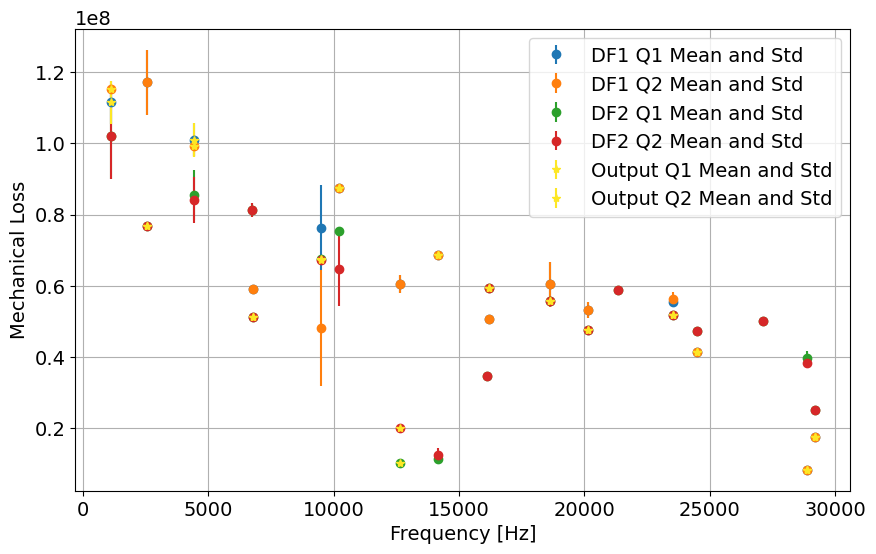

,Frequency,Q1 Mean,Q2 Mean,Q1 Max,Q2 Max,Q1 Min,Q2 Min,Q1 Std,Q2 Std,m,n
0,1116.70,86699.75,96646.5,89630.0,110890.0,83356.0,83356.0,2236.746116,10787.863401,0,2
1,2562.00,97967.25,99598.5,100640.0,100640.0,94105.0,97674.0,2467.038242,1211.864988,0,3
2,4458.70,96660.40,96660.4,99868.0,99868.0,93819.0,93819.0,2518.151592,2518.151592,0,4
3,6792.50,91349.20,91349.2,95269.0,95269.0,87820.0,87820.0,2599.075713,2599.075713,0,5
4,9551.25,108642.50,108642.5,109300.0,109300.0,108050.0,108050.0,518.236191,518.236191,0,6

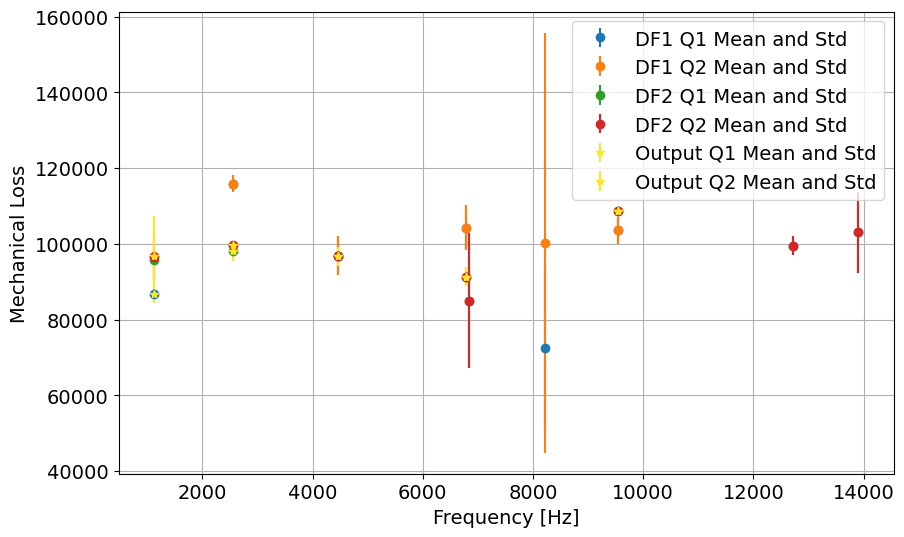

In [15]:
#Inputs required stack sample variables

s                   =  serials[0] #S1600962                # disk serial numberS1600962
material            = [materials[0]]              # material or stack name
thickness           = [d_T[0]]                   # film thickness in [m]
density             = [av_stack_density[0]]


date_uncoated       = uncoated_measurements[s]             # date of uncoated suspension you wish to analyse


date_coated         = coated_measurements[s]             # date of coated suspension you wish to analyse
suspension_number   = '1'                        # either put in a number, i.e 2 (doesn't have to be string) or 'best' as a string for the best value set


thickness_substrate = [1.0235]                   # substrate thickness in [mm], INPUT AS LIST.   If using any pycrime data from DCC look at the "mode_id" output graph for thickness info FOR THE UNCOATED disk
Y_substrate         = [73.2]                     # substrate Young's modulus in [GPa], INPUT AS LIST
nu_substrate        = [0.167]                    # substrate Poisson Ratio, INPUT AS LIST
density_substrate   = [2220.]                    # substrate density in kg/m^3, INPUT AS LIST



temperature         = 30                        # heat treatment temperature, input as integer
duration            = 0                        # heat treatment duration, input as integer


TF_uncoated         = False                       # True / False = Bayesian fits to the already analysed data or not
TF_coated           = False                     # True / False = Bayesian fits to the already analysed data or not
 

# User input to remove bad modes by giving the mode ID [2,5,8,9,etc] or ['none'].
coated_duplicate_mode_IDS =['none']              # e,g [3,9] removes the data of the 4th and 10th coated modes because of bad measurement or for matching with uncoated data
blank_duplicate_mode_IDS = ['none']              # e,g [3,9] removes the data of the 4th and 10th uncoated modes because of bad measurement or for matching with coated data


# You can also use bad_mode_IDS to remove things as well, it's slightly more automated in that it will remove the same mode from both datasets however
# it was built before the two above and I prefer to use these and set bad_mode_IDS to ['none']

# Used if a mode appears in both uncoated and coated sets BUT the measurement for either was bad/significantly off trend
bad_mode_IDS        = ['none']                   # user input to remove bad modes by giving the mode ID [2,5,8,9,etc] or ['none'].            




# The best data textfiles will need to be in your current directory and need to be in the form shown below, i.e best Q entered twice , or a Q1 and Q2 estimate etc
blankreplace = ['no']                           # ['yes']/['no'] this is here to rewrite the data it's currently working with for 1 suspension with the best data from multiple 
coatedreplace = ['no']

base_path         = '/Users/simon/Desktop/CRIME_BACKUP/'

uncoated_data , best_uncoated_data,best_uncoated_std =   best_results(serials=serials,base_path=base_path,measurement_dates=date_uncoated,verbose=False,plots=True)

coated_df,      best_coated_data   ,best_coated_std  = best_results(serials=serials,base_path=base_path,measurement_dates=date_coated,verbose=False,plots=True)

## write to text files so that they can be in the same format as Graemes Code 

outdata = uncoated_data.iloc[:, [0,1,2,9,10]] 
Q_SUB_txt =os.path.join("/Users/simon/Desktop/CRIME_BACKUP/results/CSU_TiGemania",f"{s}",f"{s}_Best_uncoated.txt")
outdata.to_csv(Q_SUB_txt, sep='\t', index=False)

outdata = uncoated_data.iloc[:, [7,8]] 
ERR_SUB_txt =os.path.join("/Users/simon/Desktop/CRIME_BACKUP/results/CSU_TiGemania",f"{s}",f"{s}_Best_uncoated_Errors.txt")
outdata.to_csv(ERR_SUB_txt, sep='\t', index=False)

outdata = coated_df.iloc[:, [0,1,2,9,10]] 
Q_ED_txt =os.path.join("/Users/simon/Desktop/CRIME_BACKUP/results/CSU_TiGemania",f"{s}",f"{s}_Best_AsDeposited.txt")
outdata.to_csv(Q_ED_txt, sep='\t', index=False)

outdata = coated_df.iloc[:, [7,8]] 
ERR_ED_txt =os.path.join("//Users/simon/Desktop/CRIME_BACKUP/results/CSU_TiGemania",f"{s}",f"{s}_Best_AsDeposited_Errors.txt")
outdata.to_csv(ERR_ED_txt, sep='\t', index=False)



MAX_FREQ_DIFF = 400;                             # this defines the max frequency shift analysis cutoff, will want it around 500Hz for a stack (can keep it as this for single layyer too but probably only needs to be  ~50Hz)

In [16]:
import sys
sys.path.append('/Users/simon/Desktop/CRIME_BACKUP/results/CSU_TiGemania/pycrime-supplementary-effective-medium-coating-analysis-main/')
from stack_values_extractor_replacingvalues import *


# Match Uncoated nd Coated modes and run quick coating loss analysis on stack, pulling out measured COATED Qs at the corresponding frequencies

set_ylimit = ['no']    # manually choose if you want to set y axis limits for coating loss graph ['yes'] for manual, ['no'] for automatic
YLIMT= [0, 0.012]     # manual specifications for y axis limits for output coating loss graph units of x10^{-3}. 

# calculates coating loss of the disk you just input details for, mostly used in this anaysis for stacks, but no reason it cant be done for single layers


"""
print(f"s{s}")
print(f"material{material}")
print(f"thickness{thickness}")
print(f"density{density}")
print(f"Y_substrate{Y_substrate}")
print(f"nu_substrate{nu_substrate}")
print(f"density_substrate{density_substrate}")
print(f"thickness_substrate{thickness_substrate}")
print(f"temperature{temperature}")
print(f"duration{duration}")
print(f"date_uncoated{date_uncoated}")
print(f"date_coated{date_coated}")
print(f"suspension_number{suspension_number}")
print(f"TF_uncoated{TF_uncoated}")
print(f"TF_coated{TF_coated}")
print(f"coated_duplicate_mode_IDS{coated_duplicate_mode_IDS}")
print(f"blank_duplicate_mode_IDS{blank_duplicate_mode_IDS}")
print(f"bad_mode_IDS{bad_mode_IDS}")
print(f"YLIMT{YLIMT}")
print(f"coatedreplace{coatedreplace}")
print(f"Q_ED_txt{Q_ED_txt}")
print(f"ERR_ED_txt{ERR_ED_txt}")
print(f"blankreplace{blankreplace}")
print(f"Q_SUB_txt{Q_SUB_txt}")
print(f"ERR_SUB_txt{ERR_SUB_txt}")
print(f"MAX_FREQ_DIFF{MAX_FREQ_DIFF}")
"""

f_stack, m_exp, uncoated_ave_stack, uncoated_std_stack, coated_ave_stack,\
    coated_std_stack, Dbulk, Dshear, comsol_modes, s2ds, s2delplus6s=stack_values_extractor_replacingvalues(s, material, thickness, density,\
        Y_substrate, nu_substrate, density_substrate, thickness_substrate,\
        temperature, duration, date_uncoated, date_coated, suspension_number, \
        TF_uncoated, TF_coated, coated_duplicate_mode_IDS, blank_duplicate_mode_IDS,\
        bad_mode_IDS, YLIMT,coatedreplace, Q_ED_txt, ERR_ED_txt, blankreplace, Q_SUB_txt, ERR_SUB_txt, MAX_FREQ_DIFF)
    


ModuleNotFoundError: No module named 'pycrime'

## In this next part we do some user checking

## Some of outputs of this function have been pulled out from fitting to a pre generated comsol library. Specifically our dilution factors and strains have been assigned to the comsol modes fit to a model, based on the input material properties and fshift the function calculates, and not the exact measured modes. This means we are outputing some modes we dont need (the comsol library is always bigger as it encompasses the first 25 possible measureable modes, all of which we never see) .  in this next part we will visually compare our measured experimental (m_exp) and modelled modes (comsol_modes) and remove the indexes of the unused modes.  This is vital for making the later effective medium estimates operate correctly.

## This could all, and use to be, automated, but sometimes modes are misidentified and incorrectly assigned in real data, in checking the order after removal of the not measured ones, and in checking the corresponding fshift trend (can take code snippet from stack_values_extractor_replacingvalues function to do this), you can identify the correct order.  Because of the potential misidenification/assignment/ordering, i like to spend <3mins to check this manually, so i can be confident that my mode identification is correct, and the resulting dilution factors and strains are also accurate. 


In [ ]:
print((f_stack))            # measured frequecnies list

print(shape(m_exp))
print(shape(comsol_modes))
print(m_exp)                # measured mode list [m n] - m: number of nodal circles n:number of nodal lines


In [ ]:
print(comsol_modes)         # modelled modes list [m n]

In [ ]:
def ismember(a, b):
    # Ensure a and b are NumPy arrays
    a = np.asarray(a)
    b = np.asarray(b)
    
    # Initialize an empty list to store indices of matching rows
    matches = []
    
    # Iterate over each row in array a
    for row in a:
        # Check if the row exists in array b
        match = np.where(np.all(b == row, axis=1))[0]
        if len(match) > 0:
            matches.append(match[0])
        else:
            matches.append(None)
    
    return matches

# Example usage:

# Find membership of rows in m_exp within comsol_modes
matches = ismember(np.array(m_exp), np.array(comsol_modes))
print(comsol_modes[matches])

mask = np.zeros(len(comsol_modes), dtype=bool)
mask[matches] = True


print(mask  )

# Use the mask to select elements to keep

comsolmod       = comsol_modes[mask]
dbulk           = Dbulk[mask]
dshear          = Dshear[mask]
s2dscut         = s2ds[mask]
s2delplus6scut  = s2delplus6s[mask]

"""
#quick cuting of dbulk,dshear,s2ds s2del6s etc

remove_coated_modes =[2,3,7,8,16,21,23,24] #index of the bad modes from 0 to length(comsol_modes), 2 and 8 are almost never measured as an example
#2,8,16,18,19,21,23,24
comsolmod =np.delete(comsol_modes, remove_coated_modes, axis = 0)
dbulk =np.delete(Dbulk, remove_coated_modes, axis = 0)
dshear =np.delete(Dshear, remove_coated_modes, axis = 0)
s2dscut =np.delete(s2ds, remove_coated_modes, axis = 0)
s2delplus6scut =np.delete(s2delplus6s, remove_coated_modes, axis = 0)
"""

In [ ]:
print((f_stack))

In [ ]:
def check_lengths(f_stack, comsolmod, dbulk, dshear):
    """
    Check if the lengths of the first three arrays are the same.
    
    Parameters:
        f_stack (numpy.ndarray): First array.
        comsolmod (numpy.ndarray): Second array.
        dbulk (numpy.ndarray): Third array.
        dshear (numpy.ndarray): Fourth array.
    
    Returns:
        bool: True if the lengths are the same, False otherwise.
    """
    lengths = [len(arr) for arr in [f_stack, comsolmod, dbulk]]
    return len(set(lengths)) == 1

def check_ordering(comsolmod, m_exp):
    """
    Check if the last two arrays have the same ordering.
    
    Parameters:
        comsolmod (numpy.ndarray): Second-to-last array.
        m_exp (numpy.ndarray): Last array.
    
    Returns:
        bool: True if the ordering is the same, False otherwise.
    """
    return np.array_equal(comsolmod, m_exp)

# if the first 3 here all have the same length that is a good first check
print("Check Lengths:", check_lengths(f_stack, comsolmod, dbulk, dshear))

# if the last 2 have the same ordering on visual inspection that is your second check cutting has been done correctly
print("Check Ordering:", check_ordering(comsolmod, m_exp))


# 3rd check if unfamiliar with the particular geometry is to run the fshift checker code snippet from the stack_extractor function and see how well the trends match predictions a disagreement might point toward any misassignment that has coincidentally happened in both. of note the [0 8] and [2 2] mode are always close in frequency and a real effect/sample damage, could conceivably switch them but usually unlikely

print(shape(f_stack))
print(shape(comsolmod))
print(shape(dbulk))    # eg fractional energy stored in bulk 
print((dbulk+dshear))  # dilution factor 
print(comsolmod.T)   
print(m_exp.T)

## If the cut-comsol and measured modes above are the same and in the exact same order, you can move on to the next part.

In [ ]:
#sum of bulk and sheat dilutution factors is equivalent to Ecoating/Etotal 
ER=(dbulk+dshear)
print(ER.T)

# ER is the total fraction of energy in the coating with respect to the energy in the substrate in a particular shape of motion - you may wish to save this as it's own variable for use in other analysis separate to this.
# (we have added the coating bulk and shear dilution factor together for each mode shape)

In [ ]:
print(shape(uncoated_ave_stack))
print(shape(coated_ave_stack))
print(shape(f_stack))
print((f_stack))
print(coated_ave_stack[:,0])

In [ ]:
## (2)

## NOW ONTO SINGLE LAYER ESTIMATES WHERE WE WILL PULL OUT VARIABLES TO IMPLEMENT OUR EFFECTIVE MEDIUM ANALYSIS ON

## To run this section on it's own, you will need at least some fstack array first


In [ ]:
#dummy fstack data in case for some reason you are skipping these first parts and want to go straight to some sngle layer estimates, note using these will mess up later coated loss estimates as dilution factors will not be correct 

# fa=[1119.075,2567.95,4469.6375,6809.8,6863.5875,9576.1375,10337.3875,12758.2375,14333.05,16298.55,16346.7375,18820.575,20332.75,23777.42857,24707.975,29184.3]
# FSTACK =np.array(fa)
# f_stack=FSTACK
# shape(FSTACK)


## When you run the anaysis below it will estimate fits for the loss dependence with frequency - and it will tell you its best from among 6 trial models.  
## It will output 6 graphs and 6 corner plots and tell you which is the most likely.  You should check to see these to see they look sensible and lie within your preset bounds
## It will also spit out variables needed for the effective medium analysis in the next step at the exact frequencies they appear in the stack

## Once you are happy with the best fit model, and it's bounds, update the model_slope and model_split variable to just be the best fit one to save you running the whole analysis again.
## You can also adjust walkers, iterations, and warmups to make the model run faster, the most common one i use balancing between time and good resolution is 200, 4000,2000 respectively but this typically takes 5mins per model!
## Starting I would use 100,1000 and 500 respectively for first quick estimates, while you play with your other bounds and input slope/exponent etc


In [ ]:
#SINGLE LAYER MATERIAL 1 

#Input required same as before but with a few additions

idx = 6 

s                   =  serials[idx] #S1600968                # disk serial numberS1600962

material            = [materials[idx]]              # material or stack name
thickness           = [d_T[idx]]                   # film thickness in [m]
density             = [av_stack_density[idx]]


date_uncoated       = uncoated_measurements[s]             # date of uncoated suspension you wish to analyse


date_coated         = coated_measurements[s]             # date of coated suspension you wish to analyse
suspension_number   = '1'                        # either put in a number, i.e 2 (doesn't have to be string) or 'best' as a string for the best value set


thickness_substrate = [1.0175]                   # substrate thickness in [mm], INPUT AS LIST.   If using any pycrime data from DCC look at the "mode_id" output graph for thickness info FOR THE UNCOATED disk
Y_substrate         = [73.2]                     # substrate Young's modulus in [GPa], INPUT AS LIST
nu_substrate        = [0.167]                    # substrate Poisson Ratio, INPUT AS LIST
density_substrate   = [2220.]                    # substrate density in kg/m^3, INPUT AS LIST



temperature         = 30                        # heat treatment temperature, input as integer
duration            = 0                        # heat treatment duration, input as integer


TF_uncoated         = False                       # True / False = Bayesian fits to the already analysed data or not
TF_coated           = False                     # True / False = Bayesian fits to the already analysed data or not
 

# User input to remove bad modes by giving the mode ID [2,5,8,9,etc] or ['none'].
coated_duplicate_mode_IDS =['none']              # e,g [3,9] removes the data of the 4th and 10th coated modes because of bad measurement or for matching with uncoated data
blank_duplicate_mode_IDS = ['none']              # e,g [3,9] removes the data of the 4th and 10th uncoated modes because of bad measurement or for matching with coated data


# You can also use bad_mode_IDS to remove things as well, it's slightly more automated in that it will remove the same mode from both datasets however
# it was built before the two above and I prefer to use these and set bad_mode_IDS to ['none']

# Used if a mode appears in both uncoated and coated sets BUT the measurement for either was bad/significantly off trend
bad_mode_IDS        = ['none']                   # user input to remove bad modes by giving the mode ID [2,5,8,9,etc] or ['none'].
#Baysian fit parameters
# These will detemine what models (up to 6) it will try to fit for [Y, nu, edge, and phi fit parameters] and how computationally intensive it will be

model_slope         = ['powerlaw', 'linear', 'constant']     # tell it what kinds of models to test from among ['powerlaw', 'linear', 'constant']                     
model_split         = ['bulk_shear', 'equal']                # tell it what kinds of models to test from among ['bulk_shear', 'equal'] 
walkers             = 200                                    # number of walkers for MCMC process
iterations          = 4000                                   # number of iterations of MCMC process
warmups             = 2000                                   # number of inital iterations to discard

#Bounds/initial for the MCMC trials of all the variables
Y_range             = [40, 200]                              # Youngs Modulus constraints 
nu_range            = [0.05, 0.5]                            # Poisson Ratio constraints
edge_range          = [-2.5, 2.5]                            # edge constraints 
phi_range           = [0, 200]                               # single phi constraint
PL_exp_val          = 1                                      # phi fit exponent initial guess value, probably start with 1
LIN_slope_val       = 2                                      # phi fit initial guess value, probably start with 1

F_STACK = f_stack                                            # this is written like this here mostly to remind you, dear reader, that you need frequncy locations corresponding to those of the stack from the previous part


coated_duplicate_mode_IDS =['none']                          # same as before
blank_duplicate_mode_IDS =['none']                           # same as before

bad_mode_IDS_SL =['none']                         # same as before #['none'] #in this particular case I removed all modes above 25kHz and one bad mode at 20kHz (index 10)



#You can mostly ignore these 2 a green coloured plot will also be output displaying one of the phi bulk or phi shear fit of the best fitting model, these are the y_axis bounds, ignor this graph and focus on the other six 
low = 1e-6
up = 4e-4



base_path         = '/home/controls/CRIME/results/'

uncoated_data , best_uncoated_data,best_uncoated_std =   best_results(serials=[s],base_path=base_path,measurement_dates=date_uncoated,verbose=False,plots=False)

coated_df,      best_coated_data   ,best_coated_std  = best_results(serials=[s],base_path=base_path,measurement_dates=date_coated,verbose=False,plots=False)

## write to text files so that they can be in the same format as Graemes Code 

outdata = uncoated_data.iloc[:, [0,1,2,9,10]] 
Q_SUB_txt =os.path.join("/mnt/data/CRIME/results/CSU_TiGemania",f"{s}",f"{s}_Best_uncoated.txt")
outdata.to_csv(Q_SUB_txt, sep='\t', index=False)

outdata = uncoated_data.iloc[:, [7,8]] 
ERR_SUB_txt =os.path.join("/mnt/data/CRIME/results/CSU_TiGemania",f"{s}",f"{s}_Best_uncoated_Errors.txt")
outdata.to_csv(ERR_SUB_txt, sep='\t', index=False)

outdata = coated_df.iloc[:, [0,1,2,9,10]] 
Q_ED_txt =os.path.join("/mnt/data/CRIME/results/CSU_TiGemania",f"{s}",f"{s}_Best_AsDeposited.txt")
outdata.to_csv(Q_ED_txt, sep='\t', index=False)

outdata = coated_df.iloc[:, [7,8]] 
ERR_ED_txt =os.path.join("/mnt/data/CRIME/results/CSU_TiGemania",f"{s}",f"{s}_Best_AsDeposited_Errors.txt")
outdata.to_csv(ERR_ED_txt, sep='\t', index=False)



In [ ]:
from tabulate import tabulate

# Data as dictionary
data = {
    "Parameter": ["idx", "s", "material", "thickness", "density", "date_uncoated", "date_coated",
                  "suspension_number", "thickness_substrate", "Y_substrate", "nu_substrate",
                  "density_substrate", "temperature", "duration", "TF_uncoated", "TF_coated",
                  "coated_duplicate_mode_IDS", "blank_duplicate_mode_IDS", "bad_mode_IDS",
                  "model_slope", "model_split", "walkers", "iterations", "warmups", "Y_range",
                  "nu_range", "edge_range", "phi_range", "PL_exp_val", "LIN_slope_val",
                  "F_STACK", "coated_duplicate_mode_IDS", "blank_duplicate_mode_IDS",
                  "bad_mode_IDS_SL", "low", "up", "blankreplace", "Q_SUB_txt", "ERR_SUB_txt",
                  "coatedreplace", "Q_ED_txt", "ERR_ED_txt"],
    "Value": [idx, s, material, thickness, density, date_uncoated, date_coated,
              suspension_number, thickness_substrate, Y_substrate, nu_substrate,
              density_substrate, temperature, duration, TF_uncoated, TF_coated,
              coated_duplicate_mode_IDS, blank_duplicate_mode_IDS, bad_mode_IDS,
              model_slope, model_split, walkers, iterations, warmups, Y_range,
              nu_range, edge_range, phi_range, PL_exp_val, LIN_slope_val,
              F_STACK, coated_duplicate_mode_IDS, blank_duplicate_mode_IDS,
              bad_mode_IDS_SL, low, up, blankreplace, Q_SUB_txt, ERR_SUB_txt,
              coatedreplace, Q_ED_txt, ERR_ED_txt]
}

# Printing the table
print(tabulate(data, headers="keys", tablefmt="grid"))


In [ ]:
#Runs a MCMC fit on the input single layer data to best estimate the Y, nu, edge, and  phi b/s/equal fits for the coating material

#Returns the G_A, G_B, G_C, G_D terms which are later used to estimate the coating Qs of the material and then the coatED Qs of the stack


from singlelayer_values_extractor_replacingvalues import singlelayer_values_extractor_replacingvalues
from match_modes_gmcghee import match_modes_gmcghee
G_A_1, G_B_1, G_C_1, G_D_1, A_1, fig_1 = singlelayer_values_extractor_replacingvalues(s, material, thickness, density, Y_substrate, nu_substrate, density_substrate, thickness_substrate, temperature, duration, date_uncoated, date_coated, suspension_number, TF_uncoated, TF_coated, model_slope, model_split, walkers, iterations, warmups, Y_range, nu_range, edge_range, phi_range, PL_exp_val, LIN_slope_val, coated_duplicate_mode_IDS, blank_duplicate_mode_IDS, bad_mode_IDS_SL, F_STACK,low,up, coatedreplace, Q_ED_txt, ERR_ED_txt, blankreplace, Q_SUB_txt, ERR_SUB_txt)

In [ ]:
print(shape(G_A_1))
print(shape(G_B_1))
print(shape(G_C_1))
print(shape(G_D_1))

# These "G_#" terms are the averaging properties, needed later for the effective medium analysis -FOR MATERIAL 1

## Now repeat the same for the next single layer material 
## Ensure your MCMC walkers, iterations, and warmups in final output are the same as used for material 1

In [ ]:
#SINGLE LAYER MATERIAL 1 

#Input required same as before but with a few additions

idx = 8

s                   =  serials[idx] #S1600970               # disk serial numberS1600962

material            = [materials[idx]]              # material or stack name
thickness           = [d_T[idx]]                   # film thickness in [m]
density             = [av_stack_density[idx]]


date_uncoated       = uncoated_measurements[s]             # date of uncoated suspension you wish to analyse


date_coated         = coated_measurements[s]             # date of coated suspension you wish to analyse
suspension_number   = '1'                        # either put in a number, i.e 2 (doesn't have to be string) or 'best' as a string for the best value set


thickness_substrate = [1.014]                   # substrate thickness in [mm], INPUT AS LIST.   If using any pycrime data from DCC look at the "mode_id" output graph for thickness info FOR THE UNCOATED disk
Y_substrate         = [73.2]                     # substrate Young's modulus in [GPa], INPUT AS LIST
nu_substrate        = [0.167]                    # substrate Poisson Ratio, INPUT AS LIST
density_substrate   = [2220.]                    # substrate density in kg/m^3, INPUT AS LIST



temperature         = 30                        # heat treatment temperature, input as integer
duration            = 0                        # heat treatment duration, input as integer


TF_uncoated         = False                       # True / False = Bayesian fits to the already analysed data or not
TF_coated           = False                     # True / False = Bayesian fits to the already analysed data or not
 

# User input to remove bad modes by giving the mode ID [2,5,8,9,etc] or ['none'].
coated_duplicate_mode_IDS =['none']              # e,g [3,9] removes the data of the 4th and 10th coated modes because of bad measurement or for matching with uncoated data
blank_duplicate_mode_IDS = ['none']              # e,g [3,9] removes the data of the 4th and 10th uncoated modes because of bad measurement or for matching with coated data


# You can also use bad_mode_IDS to remove things as well, it's slightly more automated in that it will remove the same mode from both datasets however
# it was built before the two above and I prefer to use these and set bad_mode_IDS to ['none']

# Used if a mode appears in both uncoated and coated sets BUT the measurement for either was bad/significantly off trend
bad_mode_IDS        = ['none']                   # user input to remove bad modes by giving the mode ID [2,5,8,9,etc] or ['none'].
#Baysian fit parameters
# These will detemine what models (up to 6) it will try to fit for [Y, nu, edge, and phi fit parameters] and how computationally intensive it will be

model_slope         = ['powerlaw', 'linear', 'constant']     # tell it what kinds of models to test from among ['powerlaw', 'linear', 'constant']                     
model_split         = ['bulk_shear', 'equal']                # tell it what kinds of models to test from among ['bulk_shear', 'equal'] 
walkers             = 200                                    # number of walkers for MCMC process
iterations          = 4000                                   # number of iterations of MCMC process
warmups             = 2000                                   # number of inital iterations to discard

#Bounds/initial for the MCMC trials of all the variables
Y_range             = [40, 200]                              # Youngs Modulus constraints 
nu_range            = [0.05, 0.5]                            # Poisson Ratio constraints
edge_range          = [-2.5, 2.5]                            # edge constraints 
phi_range           = [0, 200]                               # single phi constraint
PL_exp_val          = 1                                      # phi fit exponent initial guess value, probably start with 1
LIN_slope_val       = 2                                      # phi fit initial guess value, probably start with 1

F_STACK = f_stack                                            # this is written like this here mostly to remind you, dear reader, that you need frequncy locations corresponding to those of the stack from the previous part


coated_duplicate_mode_IDS =['none']                          # same as before
blank_duplicate_mode_IDS =['none']                           # same as before

bad_mode_IDS_SL =['none']                         # same as before #['none'] #in this particular case I removed all modes above 25kHz and one bad mode at 20kHz (index 10)


base_path         = '/home/controls/CRIME/results/'

uncoated_data , best_uncoated_data,best_uncoated_std =   best_results(serials=[s],base_path=base_path,measurement_dates=date_uncoated,verbose=False,plots=False)

coated_df,      best_coated_data   ,best_coated_std  = best_results(serials=[s],base_path=base_path,measurement_dates=date_coated,verbose=False,plots=False)

## write to text files so that they can be in the same format as Graemes Code 

outdata = uncoated_data.iloc[:, [0,1,2,9,10]] 
Q_SUB_txt =os.path.join("/mnt/data/CRIME/results/CSU_TiGemania",f"{s}",f"{s}_Best_uncoated.txt")
outdata.to_csv(Q_SUB_txt, sep='\t', index=False)

outdata = uncoated_data.iloc[:, [7,8]] 
ERR_SUB_txt =os.path.join("/mnt/data/CRIME/results/CSU_TiGemania",f"{s}",f"{s}_Best_uncoated_Errors.txt")
outdata.to_csv(ERR_SUB_txt, sep='\t', index=False)

outdata = coated_df.iloc[:, [0,1,2,9,10]] 
Q_ED_txt =os.path.join("/mnt/data/CRIME/results/CSU_TiGemania",f"{s}",f"{s}_Best_AsDeposited.txt")
outdata.to_csv(Q_ED_txt, sep='\t', index=False)

outdata = coated_df.iloc[:, [7,8]] 
ERR_ED_txt =os.path.join("/mnt/data/CRIME/results/CSU_TiGemania",f"{s}",f"{s}_Best_AsDeposited_Errors.txt")
outdata.to_csv(ERR_ED_txt, sep='\t', index=False)



In [ ]:
#Runs a MCMC fit on the input single layer data to best estimate the Y, nu, edge, and  phi b/s/equal fits for the coating material
#Returns the G_A, G_B, G_C, G_D terms which are later used to estimate the coating Qs of the material and then the coatED Qs of the stack

from singlelayer_values_extractor_replacingvalues import singlelayer_values_extractor_replacingvalues
G_A_2, G_B_2, G_C_2, G_D_2, A_2_conts_eq, fig_2_conts_eq = singlelayer_values_extractor_replacingvalues(s, material, thickness, density, Y_substrate, nu_substrate, density_substrate, thickness_substrate, temperature, duration, date_uncoated, date_coated, suspension_number, TF_uncoated, TF_coated, model_slope, model_split, walkers, iterations, warmups, Y_range, nu_range, edge_range, phi_range, PL_exp_val, LIN_slope_val, coated_duplicate_mode_IDS, blank_duplicate_mode_IDS, bad_mode_IDS_SL, F_STACK, low, up, coatedreplace, Q_ED_txt, ERR_ED_txt, blankreplace, Q_SUB_txt, ERR_SUB_txt)

In [ ]:
# #this is an old version of the code for 1 suspesnion (so will not take in best fit data, but will manually adjust the Poison ratio for visual comparison of its effect)
# #Runs a MCMC fit on the input single layer data to best estimate the Y, nu, edge, and  phi b/s/equal fits for the coating material
# #Returns the G_A, G_B, G_C, G_D terms which are later used to estimate the coating Qs of the material and then the coatED Qs of the stack

# poisson_edit = 0.28
# from singlelayer_values_extractor_POISSONFIX import singlelayer_values_extractor_POISSONFIX
# G_A_SiO2, G_B_SiO2, G_C_SiO2, G_D_SiO2, A_SiO2_conts_eq, fig_SiO2_conts_eq = singlelayer_values_extractor_POISSONFIX(s, material, thickness, density, Y_substrate, nu_substrate, density_substrate, thickness_substrate, temperature, duration, date_uncoated, date_coated, suspension_number, TF_uncoated, TF_coated, model_slope, model_split, walkers, iterations, warmups, Y_range, nu_range, edge_range, phi_range, PL_exp_val, LIN_slope_val, coated_duplicate_mode_IDS, blank_duplicate_mode_IDS, bad_mode_IDStige, F_STACK, low, up, poisson_edit)

In [ ]:
#Checking that the estimates are made at the same number of frequencies, and the same number of trials for those frequencies - i.e do the outputs from Material 1 & 2 have the same shape?

print(shape(G_D_1))
print(shape(G_D_2))

## Now with our single layer estimates we can approximate a stack made of these 2 single layer materials (or more... it's easily adaptable) as an effective medium of the single layer material properties and estimate the loss that our disk coated with such a stack would have.

## And we can compare this to our actual measured coating stack values 

In [ ]:
#Effective medium averaging
#equation can be found in the document https://dcc.ligo.org/LIGO-T2100186/public - this is  eqn 1.2.1
#g1 and g2 here are the thickness ratios as defined at the start

#You could not have this step. I just like duplicating the variable incase i want to scrutinise how much altering one effects things overall without having to run code again
G_A1 = G_A_1
G_B1 = G_B_1
G_C1 = G_C_1
G_D1 = G_D_1

G_A2 = G_A_2
G_B2 = G_B_2
G_C2 = G_C_2
G_D2 = G_D_2

#Make effective thickness weighted  properties from those we have computed for both individual materials given our stack thickness ratio
# Remember g1 and g2 are the thickness ratios defined at the start d_1/d_total and d_2/d_total
G_A_av = (g1*G_A1) + (g2*G_A2)
G_B_av = (g1*G_B1) + (g2*G_B2)
G_C_av = (g1*G_C1) + (g2*G_C2)
G_D_av = (g1*G_D1) + (g2*G_D2)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from numpy import *
import numpy
%matplotlib inline
from pylab import *
from matplotlib.colors import LogNorm
import os
import time
from scipy.signal import *
import nds2
import pickle
import sys
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib 
import numpy as np

In [ ]:
#Estimate power disipated and energy stored in the coating at a given frequency when a mode is excited
#equations can be found in the document https://dcc.ligo.org/LIGO-T2100186/public eqns 3.3.3 and 3.3.4 where angular bracket terms are averaged as per eqn 1.2.1

power_dis = np.zeros((len(G_C_av),len(f_stack)))
u = np.zeros((len(G_A_av),len(f_stack)))

for F in range(len(f_stack)):
    for i in range(len(G_C_av)):
        power_dis[i,F] = np.pi*f_stack[F]*((G_C_av[i,F]*s2dscut[F])+(G_D_av[i,F]*s2delplus6scut[F]))
        
        u[i,F] = 0.25*((G_A_av[i]*s2dscut[F])+(G_B_av[i]*s2delplus6scut[F]))

In [ ]:
#Estimate coatING mechanical losses of the EFF MED stack: i.e. the effective coating loss from these bulk and shear properties input across frequency that would make the coatING Q...
#... that we see in the stack (effectively it's the equivalent estimate to the measured first graph spit out in part (1))

phi_coating_modelled = np.zeros((len(G_C_av),len(f_stack)))
for F in range(len(f_stack)):
    for i in range(len(G_C_av)):
        phi_coating_modelled[i,F] = power_dis[i,F]/(2*np.pi*f_stack[F]*u[i,F])

In [ ]:
#convert the measured uncoated Qs to uncoated losses

substrate_phis= np.zeros((len(substrate_Qs_CUT[:,1]),len(substrate_Qs_CUT[1,:])))

for F in range(len(substrate_Qs_CUT[1,:])):
    for i in range(len(substrate_Qs_CUT[:,1])):
        substrate_phis[i,F] =1/substrate_Qs_CUT[i,F]

In [ ]:
# will have form [1/freq, loss, std_loss, 1/m, 1/n] I.e for any first family/buttefly mode with m=0 the fourth value will be 1/0, i.e = inf, this is just my sanity check the numbers are correct
print((substrate_phis[1,:]))

In [ ]:
#Calculate what the coatED phis of the EFF MED stack should be given the estimates above for EFF MED COATING AND DIRECT MEAUSUREMENTS FOR SUBSTRATE..
# ... along with the dilution factors fitted using the measured data too. I.e we are directly back-calculating the effective medium coated disk Q, using the exact same variables...
# ... in the measured data.
phi_coatED_modelled_CUT = np.zeros((len(G_A_av),len(dbulk)))

for F in range(len(dbulk)):
    for i in range(len(G_C_av)):
        phi_coatED_modelled_CUT[i,F] =((phi_coating_modelled[i,F]-substrate_phis[F,1])*(dbulk[F]+dshear[F])) + substrate_phis[F,1]
        #phi_coatED_modelled_CUT[i,F] =((phi_coating_modelled[i,F])*(dbulk[F]+dshear[F])) + substrate_phis[F,1]
        #zero substrate approximation 
        #phi_coatED_modelled_CUT[i,F] =(phi_coating_modelled_CUT[i,F]*(Dbulk_p_CUTcut[F]+Dshear_p_CUTcut[F]))

## This below (and for phi in the cell above) will now give us estimates of the Q of the total disk resonator coated with a stack, comprising of materials hopefully equivalent to the single layers we made our estimates from, with equivelent dilution factors and strains as calculated in part (1)

In [ ]:
Q_coatED_modelled_CUT = np.zeros((len(G_A_av),len(dbulk)))

#Q_coatED_modelled_CUT_POISSONFIXED = np.zeros((len(G_A_av),len(Dbulk_p_CUTcut)))

for F in range(len(dbulk)):
    for i in range(len(G_C_av)):
        #Q_coatED_modelled_CUT_POISSONFIXED[i,F] = 1/(phi_coatED_modelled_CUT[i,F])
        Q_coatED_modelled_CUT[i,F] = 1/(phi_coatED_modelled_CUT[i,F])

## (3) Now let us plot and compare our estimates with measurements 

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from numpy import *
import numpy
%matplotlib inline
from pylab import *
from matplotlib.colors import LogNorm
import os
import time
from scipy.signal import *
import nds2
import pickle
import sys
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib 

In [ ]:
# load measured Qs,
stackbest      = coated_ave_stack
stackbest_stds = coated_std_stack

## or if loading from text file something like: 
#stackbest = loadtxt('847_10layer_asdep_coatED_Q.txt', delimiter='\t')
#stackbest_stds = loadtxt('847_10layer_asdep_coatED_Qerr.txt', delimiter='\t')

In [ ]:
#Q plot parameters

measured_color         = 'black'
estimate_color         = 'red'
# measured_color_Q2  = 'blue'

measured_marker_type   = 'x'
measured_marker_size   = 6
estimated_violin_size  = 500  #span in Hz i.e width along x-axis of violin plot estimate markers, i typically use 500Hz when dealing with dataset fspan of 1-30 kHz.

violin_low_cutoff      = 1.5  # violin lower cutoff percentile
violin_high_cutoff     = 0.2  # violin upper cutoff percentile


measured_label         = 'Measured Q'
estimate_label         = 'estimated stack Q'

legend_location        = "lower left"
Q_plot_title           = "CSU stack: (2021) 10-layers  - 600$^\circ$C 108hr coated Q results"

# x/y axis limits can be set in the bottom of the next cell and rerun, once you know the bounds you desire 

In [ ]:
#note if using single suspension data and not "best data" you should uncomment all the suffix "2" things here so you can plot both Q1 and Q2

x_measured  = stackbest[:,0]
q1_measured = stackbest[:,1]
q1_error    = stackbest_stds[:,1]
q_error1    = [q1_error ,q1_error] #y_error =[y_errormin, y_errormax]

#x2_measured =stackbest[:,0]
#q2_measured =stackbest[:,2]
#q2_error = stackbest924AD[:,2]
#q_error2 = [q2_error,q2_error]



matplotlib.pyplot.errorbar(x_measured/1000, q1_measured, yerr = q_error1, fmt =measured_marker_type, color= measured_color, markersize=measured_marker_size, capsize=measured_marker_size, label = measured_label)
#matplotlib.pyplot.errorbar(x2_measured/1000, q2_measured, yerr = q_error2, fmt ='o', color=measured_color_phi2, markersize=measured_marker_size, capsize=measured_marker_size, label = 'Measured $Q2$')
        
        
for F in range(len(f_stack)):
    
    scale = estimated_violin_size
    uncut_data=Q_coatED_modelled_CUT[:,F]
    low_percentage = violin_low_cutoff
    high_percentage = violin_high_cutoff
    low_percentile = np.percentile(uncut_data, low_percentage)
    high_percentile = np.percentile(uncut_data, 100-high_percentage)
    # Create a new variable that contains only the elements inbetween the upper and lower percentiles
    data = uncut_data[np.where((uncut_data >= low_percentile) & (uncut_data <= high_percentile))]
    #data=Q_coatED_modelled_CUT[:,F]
    
    counts, bins = np.histogram(data, bins=1000)
    remove_bin = 0 
    bins =np.delete(bins, remove_bin, axis = 0) #makes bin and count arrays the same though plot will be slightly off
    x1 = f_stack[F]+(scale*counts/max(counts))
    x2 = f_stack[F]-(scale*counts/max(counts))
    y_vi = bins
    if not F:
        matplotlib.pyplot.fill_betweenx(y_vi, x1/1000, x2/1000, color =estimate_color,alpha=0.33,label= estimate_label) #for y axis use "fill_between" not "fill_between_y"
    else:
        matplotlib.pyplot.fill_betweenx(y_vi, x1/1000, x2/1000, color =estimate_color,alpha=0.33) #for y axis use "fill_between" not "fill_between_y"

        
        

plt.legend()
matplotlib.pyplot.legend(loc = legend_location)

matplotlib.pyplot.ylabel("Quality Factor")
matplotlib.pyplot.xlabel("frequency [kHz]")
matplotlib.pyplot.gca().yaxis.grid(True) 
matplotlib.pyplot.title(Q_plot_title)
#matplotlib.pyplot.gca().set_ylim(2e5,5e5)
#matplotlib.pyplot.gca().set_xlim(0,32)




In [ ]:
print(q_error1)
print(np.reciprocal(q_error1))

In [ ]:
measured_label_phi     = 'measured QWL stack $\phi$'
estimate_label_phi     = 'estimated QWL stack $\phi$'

legend_location        = "upper left"
phi_plot_title           = "CSU TiGeO$_2$/SiO$_2$ QWL stack: (2021) 10-layers  - 600$^\circ$C 108hr  coated loss"